In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.pipeline import make_pipeline
from datetime import datetime

import moneymaker as mm
from moneymaker.data_retriever.data_retriever import get_daily_bars

plt.rcParams["axes.grid"] = True
plt.style.use('dark_background')
plt.rcParams["grid.color"] = "#222222"
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
ticker = "XOM"
start = datetime.fromisoformat("2018-03-31")
end = datetime.fromisoformat("2021-03-31")
sharadar_data = get_daily_bars(ticker, start, end)
ohlcv = make_pipeline(mm.FromSharadarToOHLCV()).fit_transform(sharadar_data)

In [3]:
# signal
# trade if stock is above 100 day max and ignore last 5 days (to ignore small pullbacks)
# only trade as long as stock is above 13 day VWEMA

def breakout(X,horizon=100,pullback=5):
    return X.rolling(horizon-pullback).max().shift(pullback).fillna(X.max())

signal_pipe = make_pipeline(
    mm.make_union(
        make_pipeline(mm.FromOHLCV('c')),
        make_pipeline(mm.FromOHLCV('c'), mm.Wrapper(breakout)),
        make_pipeline(mm.FromOHLCV('cv'), mm.VWEMA(13))
    ),
    mm.IsLargestCol(colidx=0)
)

backtest_pipe = make_pipeline(
    mm.make_union(
        make_pipeline(mm.FromOHLCV('c')),
        signal_pipe
    ),
    mm.SimpleBacktester(add_buy_and_hold=True)
)


<AxesSubplot:xlabel='date'>

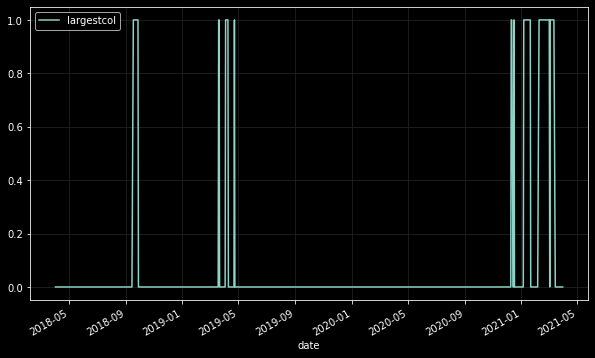

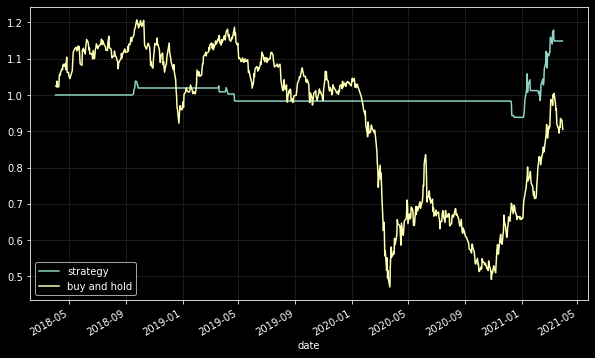

In [4]:
signal_pipe.fit_transform(ohlcv.copy()).plot()
backtest_pipe.fit_transform(ohlcv.copy()).plot()

In [5]:
open_signal_pipe = make_pipeline(
    mm.make_union(
        make_pipeline(mm.FromOHLCV('c')),
        make_pipeline(mm.FromOHLCV('c'), mm.Wrapper(breakout)),
    ),
    mm.IsLargestCol(colidx=0, final_colname="open_signal")
)

close_signal_pipe = make_pipeline(
    mm.make_union(
        make_pipeline(mm.FromOHLCV('c')),
        make_pipeline(mm.FromOHLCV('cv'), mm.VWEMA(100)),
    ),
    mm.IsLargestCol(colidx=1,final_colname="close_signal")
)

signal_pipe = make_pipeline(
    mm.make_union(
        open_signal_pipe,
        close_signal_pipe
    ),
    mm.CombineOpenCloseSignal()
)

backtest_pipe = make_pipeline(
    mm.make_union(
        make_pipeline(mm.FromOHLCV('c')),
        signal_pipe
    ),
    mm.SimpleBacktester(add_buy_and_hold=True)
)

<AxesSubplot:xlabel='date'>

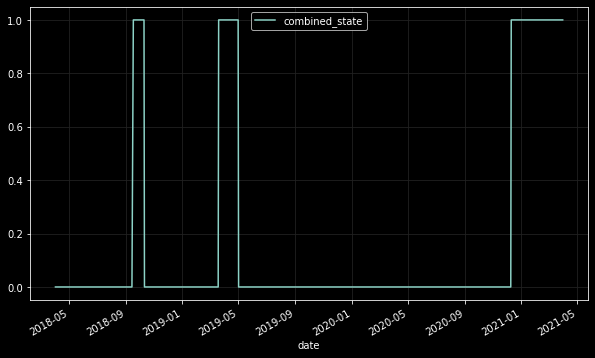

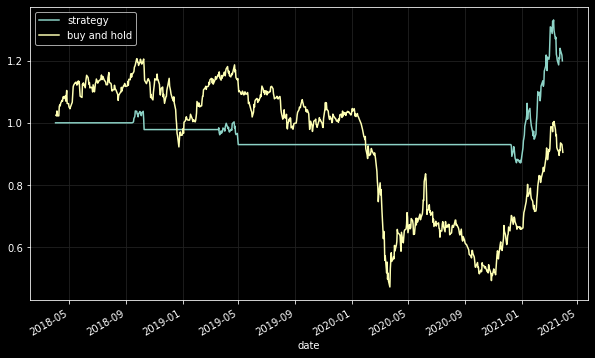

In [6]:
signal_pipe.fit_transform(ohlcv.copy()).plot()
backtest_pipe.fit_transform(ohlcv.copy()).plot()